# Python Quickstart

Most of this quick start guide is based upon the great [opentracing tutorial](https://github.com/yurishkuro/opentracing-tutorial/tree/master/python) by [Yuri Shkuro](https://github.com/yurishkuro). Once you've got a feel for how OpenTracing works here, feel free to reference his repo to learn more.

There's also a [Katakoda lesson](https://www.katacoda.com/courses/opentracing) that follows the tutorial, if you don't want to install and setup Docker on your local system just yet.

In order to run through this Quickstart, you'll need to have [Docker](https://www.docker.com/) installed on your local machine, along with Python 3. 

Once that's all setup, we'll use Docker images to interactively see how Jaeger is working.

## Running the Jaeger Container

First things first, we'll use Jupyter notebook's `!` command, to spin up our Docker image:

In [ ]:
!docker run -d -p5775:5775/udp -p6831:6831/udp -p6832:6832/udp -p5778:5778 -p16686:16686 -p14268:14268 -p9411:9411 jaegertracing/all-in-one:0.8.0

Alternately, you can open up a bash terminal, and type in the following:

```bash
$ docker run -d -p5775:5775/udp -p6831:6831/udp -p6832:6832/udp -p5778:5778 -p16686:16686 -p14268:14268 -p9411:9411 jaegertracing/all-in-one:0.8.0
```

Either way, once Docker downloads your image, you should be able to go to [localhost:16686](http://localhost:16686), and see Jaeger running. 

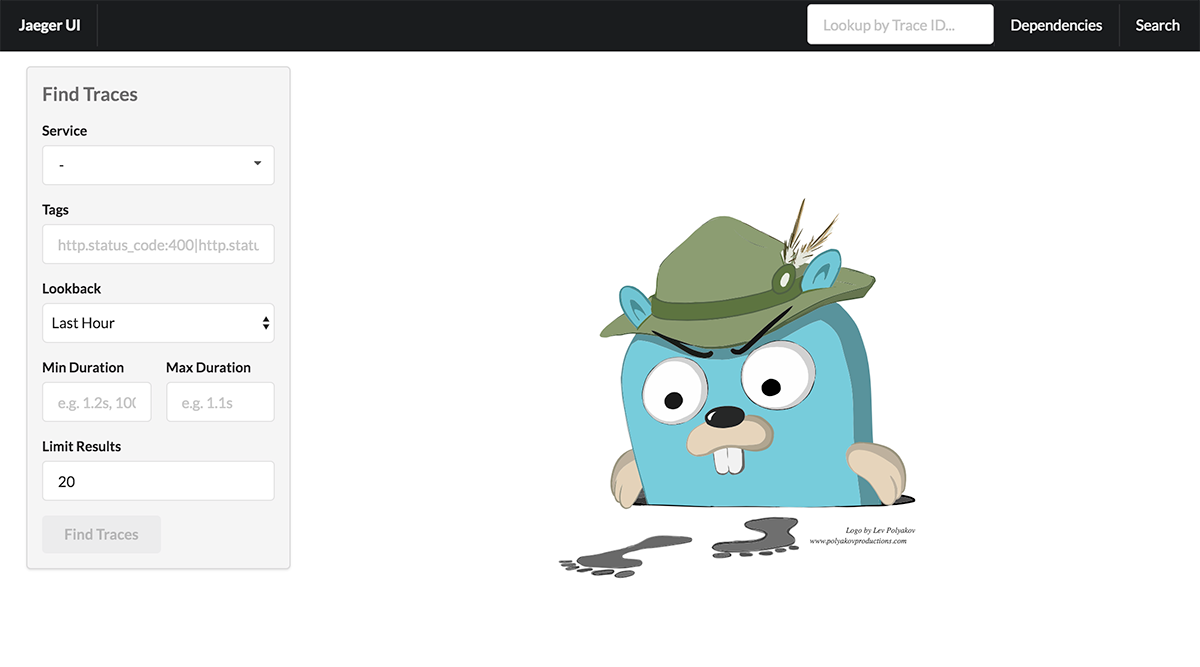

We're now ready to start shipping our Traces to our machine.

## Installing an OpenTracing Library for Python

With the Jaeger server running, we've now got a place to ship our traces to. We'll now need to set up Python to be able to ship traces.

For our example, we'll start with the [Jaeger Python bindings](https://github.com/jaegertracing/jaeger-client-python) of OpenTracing. The binding is installable with `pip`.

In [ ]:
!pip install jaeger-client

>**Wait, why am I not installing opentracing-python?!**

>[opentracing-python](https://github.com/opentracing/opentracing-python) is just a reference API. It's an empty shell if you will, that each OpenTracing platform must then implement themselves. Changing platforms should just mean changing the initialization of your `tracer` object, and the rest of your code should stay the same.

It's up to the shipping platforms themselves to implement and extend the API to ship traces to their APIs. 

Since we're using Jaeger, we'll use Jaeger's library to ship our traces.

If we were using Datadog or Lightstep's tracers, we'd use their libraries instead. The same applies to any other platform that implements the OpenTracing API.


## Configuring the Tracer

Now we have a way to ship our Traces from Python, and can jump in and configure a program to be instrumented.

Let's do that now. We'll initialize and configure Jaeger's Python bindings to ship to our local Docker container:

In [ ]:
import logging
from jaeger_client import Config


def init_tracer(service):
    logging.getLogger('').handlers = []
    logging.basicConfig(format='%(message)s', level=logging.DEBUG)

    config = Config(
        config={
            'sampler': {
                'type': 'const',
                'param': 1,
            },
            'logging': True,
        },
        service_name=service,
    )

    # this call also sets opentracing.tracer
    return config.initialize_tracer()

# Finally, create our actual tracer:
tracer = init_tracer('first-service')

## Creating Our First Span

With our new `tracer`, we can now ship our first trace, using a context:

In [ ]:
with tracer.start_span('first-span') as span:
    span.set_tag('first-tag', '100')


Typing these lines into the iPython session, we should then see a line that says the span is being reported. 

One important note here, the tracer **does not** flush immediately. If you were to run this in a program, it might exit before the tracer gets a chance to flush, and may not actually end up sending your trace.

In most web / API applications, this shouldn't matter, as your program will be long running. But if you're trying to trace a smaller application, it helps to be aware of this caveat.

Next, we can reload the [Jaeger page](http://localhost:16686/search), and see our service in the list of services, along with the trace and span. You may need to click the `Find Traces` button to see your traces.

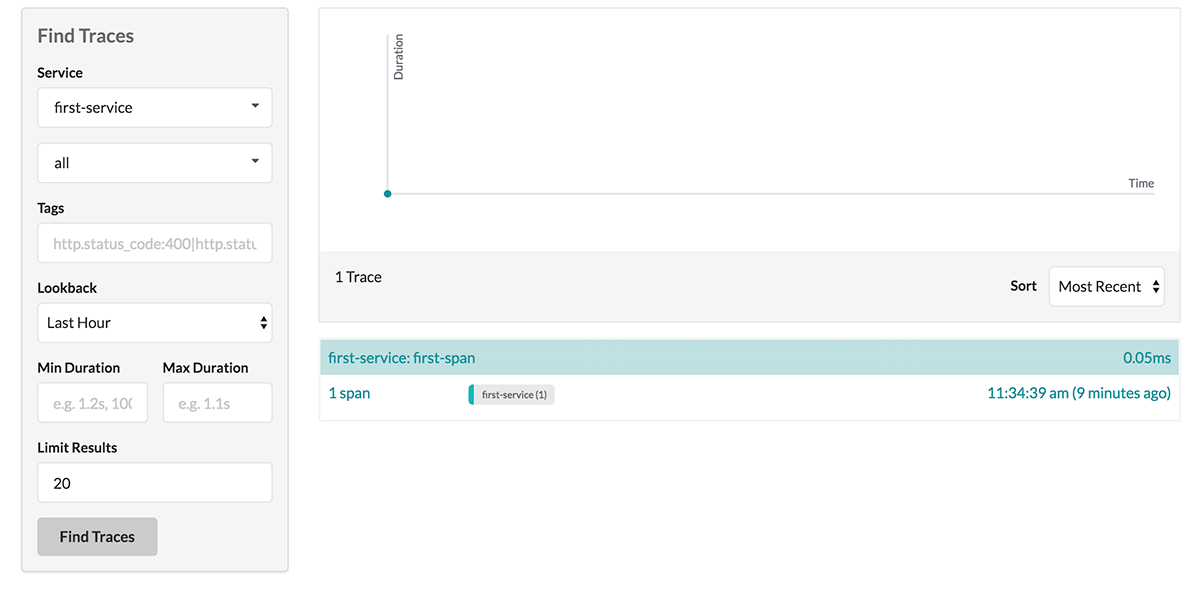

If we click on the span itself, we can see more information. Drilling down further, we can see the tag we set:

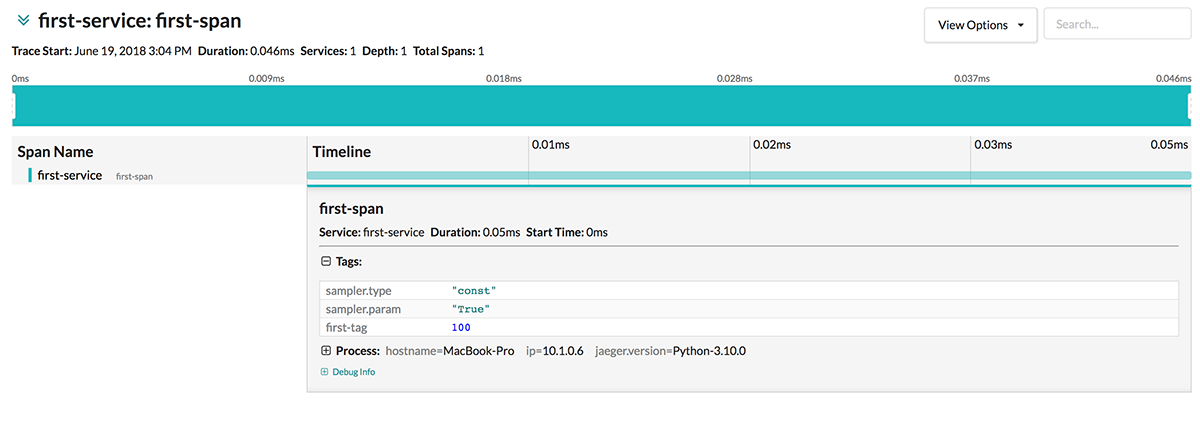

Notice that our tag we set is visible under the span. This is a good place to put debug information you may want to use to correlate to what's happening.

# Creating A Child Span 

Creating a child is done by creating tracer span as a `child_of` the parent span. Let's try that now, and see how it changes our `span`s in Jaeger:

In [ ]:
with tracer.start_span('second-span') as span2:
    span2.set_tag('second-tag', '200')
    with tracer.start_span('third-span', child_of=span2) as span3:
        span3.set_tag('third-tag', '300')


After running this code in our `ipython` repl, we can now go into Jaeger, and see our `fifth-span` successfully made a child of `fourth-span`. 

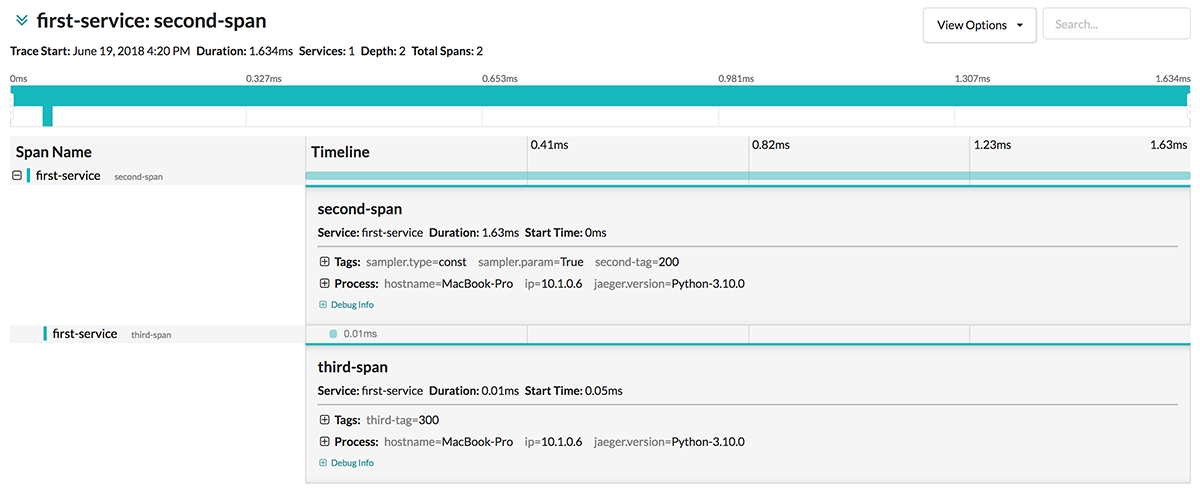

Try putting some delays between our spans to see how this affects your timeline. You'll start to get a feel for how spans show different delays of time.

## Tracing a HTTP Requests

Tracing is most useful when we get to see what's going on in our systems. Let's do two HTTP requests that rely on each other, and see how tracing allows us to visualize the process.

We'll use the `requests` library to do some HTTP GETs on the [Github jobs API](https://jobs.github.com/api). If you don't have `requests` installed, you can run the following command to get it installed via pip:


In [ ]:
!pip install requests

Next, let's try running a request to get a list of the first 50 Python jobs, and then try grabbing each job listing's company site:

In [ ]:
import requests
with tracer.start_span('get-python-jobs') as span:
    homepages = []
    res = requests.get('https://jobs.github.com/positions.json?description=python')
    span.set_tag('jobs-count', len(res.json()))
    for result in res.json():
        with tracer.start_span(result['company'], child_of=span) as site_span:
            print('Getting website for %s' % result['company'])
            try:
                homepages.append(requests.get(result['company_url']))
                site_span.set_tag('request-type', 'Success')
            except:
                print('Unable to get site for %s' % result['company'])
                site_span.set_tag('request-type', 'Failure')

If you were paying attention, you saw the new spans we created. 

One span encapsulates the job of getting the initial API request, and a new span is created for each request attempting to grab the homepage of a job's company.

If we go into the Jaeger dashboard, we can see the requests, along with their information:

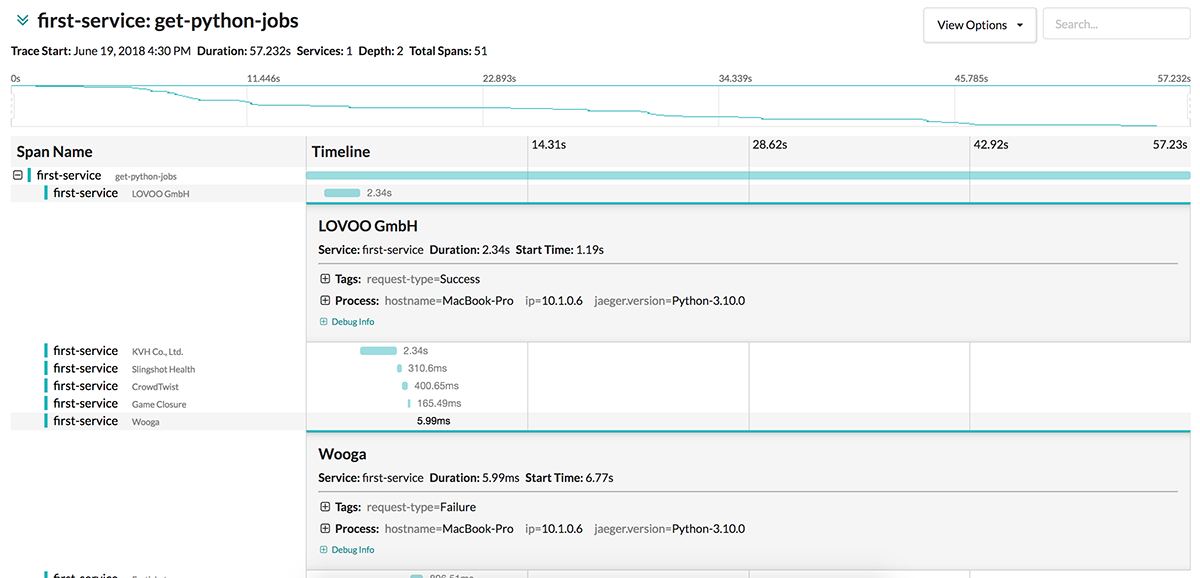

Looking here, we can see which company website is slowest to be fetched, and which is fastest. Which company would you rather be on? The one with the slow corporate site, or the fast one? 